In [7]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from plotly import graph_objs as go #Used To Create Publish Quality Graphs
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #Used To Create Wordcloud
from PIL import Image

import nltk #used for statistical natural language processing (NLP)
from nltk.corpus import stopwords #used for stopword processing

from tqdm import tqdm #Used As a support for nested loops
import os
import nltk
import spacy #statistical model for NER
import random
from spacy.util import compounding
from spacy.util import minibatch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Importing Dataset using pandas
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
ss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

In [8]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)




__So We have 27481 tweets in the train set and 3534 tweets in the test set.__



In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [10]:
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

__We have one null Value in the train , as the test field for value is NAN we will just remove it.__

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [12]:
train.dropna(inplace=True)

In [13]:
train.isna().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [16]:
test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

__There are no null Values in the test set.__

__EDA__

In [17]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


__Here, Selected_text is a subset of text.__

In [18]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,23013f9a40,Thank you OpenDNS for saving me from Comcast`s...,good,neutral
freq,1,1,199,11117


In [19]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


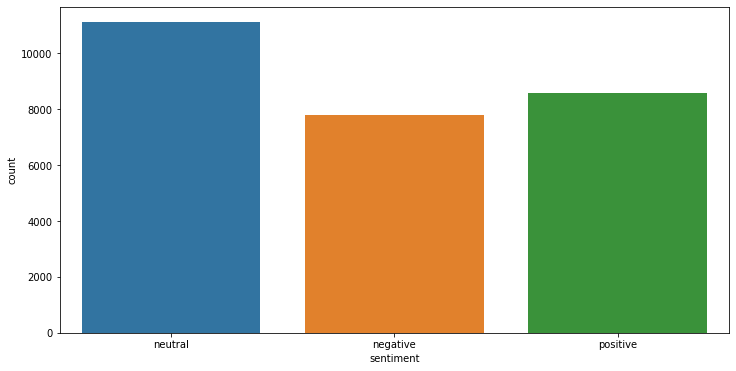

In [20]:
#Lets look at the distribution of tweets in the train set
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

__Let's draw a Funnel-Chart for better visualization.__

In [21]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

What do we currently Know About our Data:
Before starting let's look at some things that we already know about the data and will help us in gaining more new insights:

We Know that selected_text is a subset of text
We know that selected_text contains only one segment of text,i.e,It does not jump between two sentences.
For Eg:- If text is 'Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them.

Lots of fun. 
I had other plans for my morning' The selected text can be 'my boss was not happy w/ them. 

Lots of fun' or 'Lots of fun' but cannot be 'Morning,vendor and my boss,

We are not sure that preprocessing and removing punctuations would be a good idea or not.

__Jaccard Similarity Scores between text and Selected_text__

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)) #using Jaccard Index Formulae

In [ ]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [ ]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
train.head(8)

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,12,12,0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,1,14,13
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.000000,2,2,0


__Let's look at the distribution of Meta-Features.__

In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed.

In [ ]:
k = train[train['Num_word_text']<=2]

In [ ]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [ ]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


Thus its clear that most of the times , text is used as selected text.

We can improve this by preprocessing the text which have word length less than 3.
We will remember this information and use it in model building

__Cleaning the Corpus:__

Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data.

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+http://', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


__Finding Most Common words in our Target-Selected Text__

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split()) #Creates a Gradient list
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3535
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . 
Let's try again after removing the stopwords.


In [ ]:
#import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

__Finding Most Common words in Text:__
    
Let's also look at the most common words in Text

In [ ]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [ ]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments .

That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.

It will be interesting to see the word unique to different sentiments.

__Finding Unique Words in each Segment:__

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [ ]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


___By Looking at the Unique Words of each sentiment, we now have much more clarity about the data,
these unique words are very strong determiners of Sentiment of tweets___

__WordClouds:__
    
We will be building wordclouds in the following order:

1) WordCloud of Neutral Tweets

2) WordCloud of Positive Tweets

3)WordCloud of Negative Tweets

In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 
    


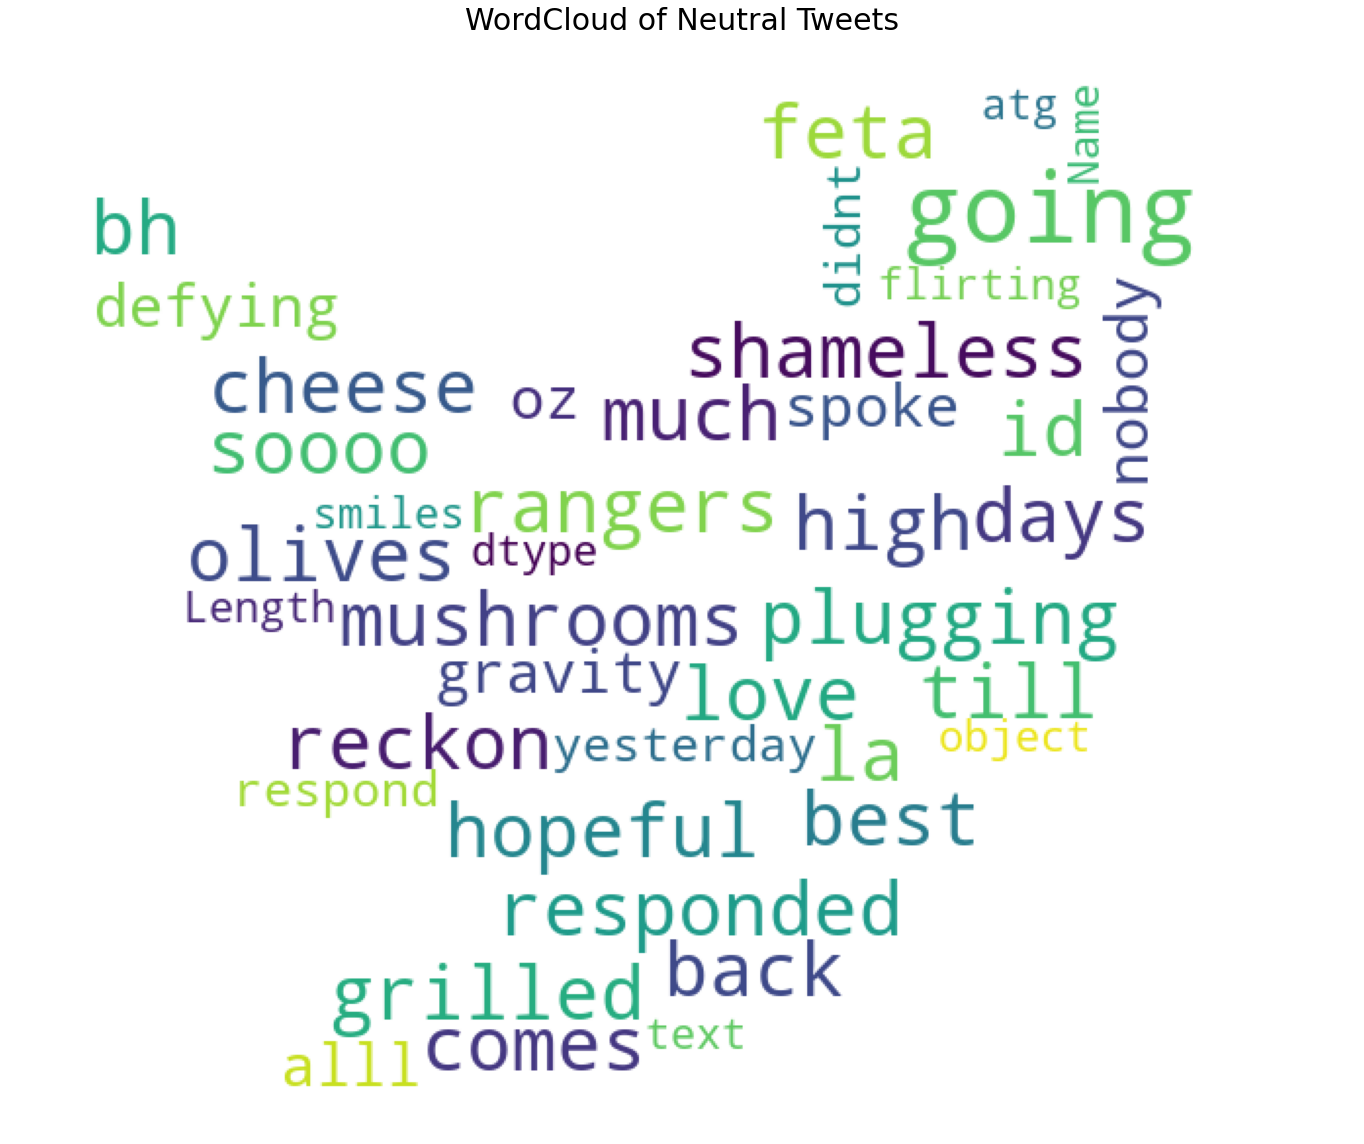

In [ ]:
pos_mask = np.array(Image.open('/content/drive/My Drive/TweetsData/download.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=50,title_size=30,title="WordCloud of Neutral Tweets")

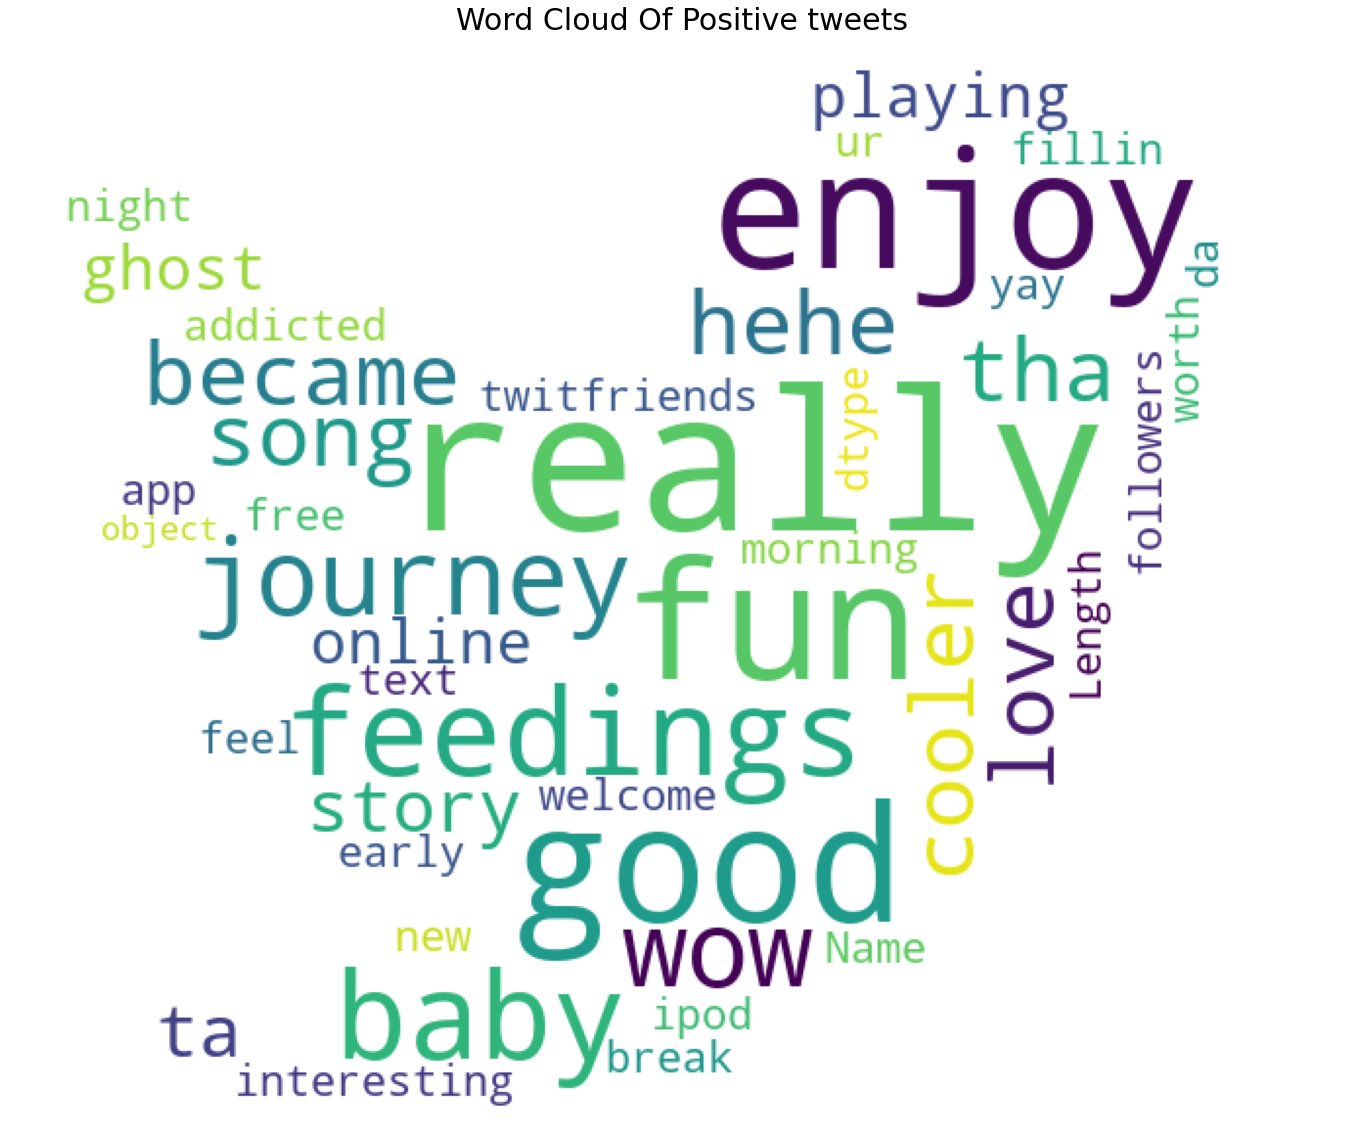

In [ ]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

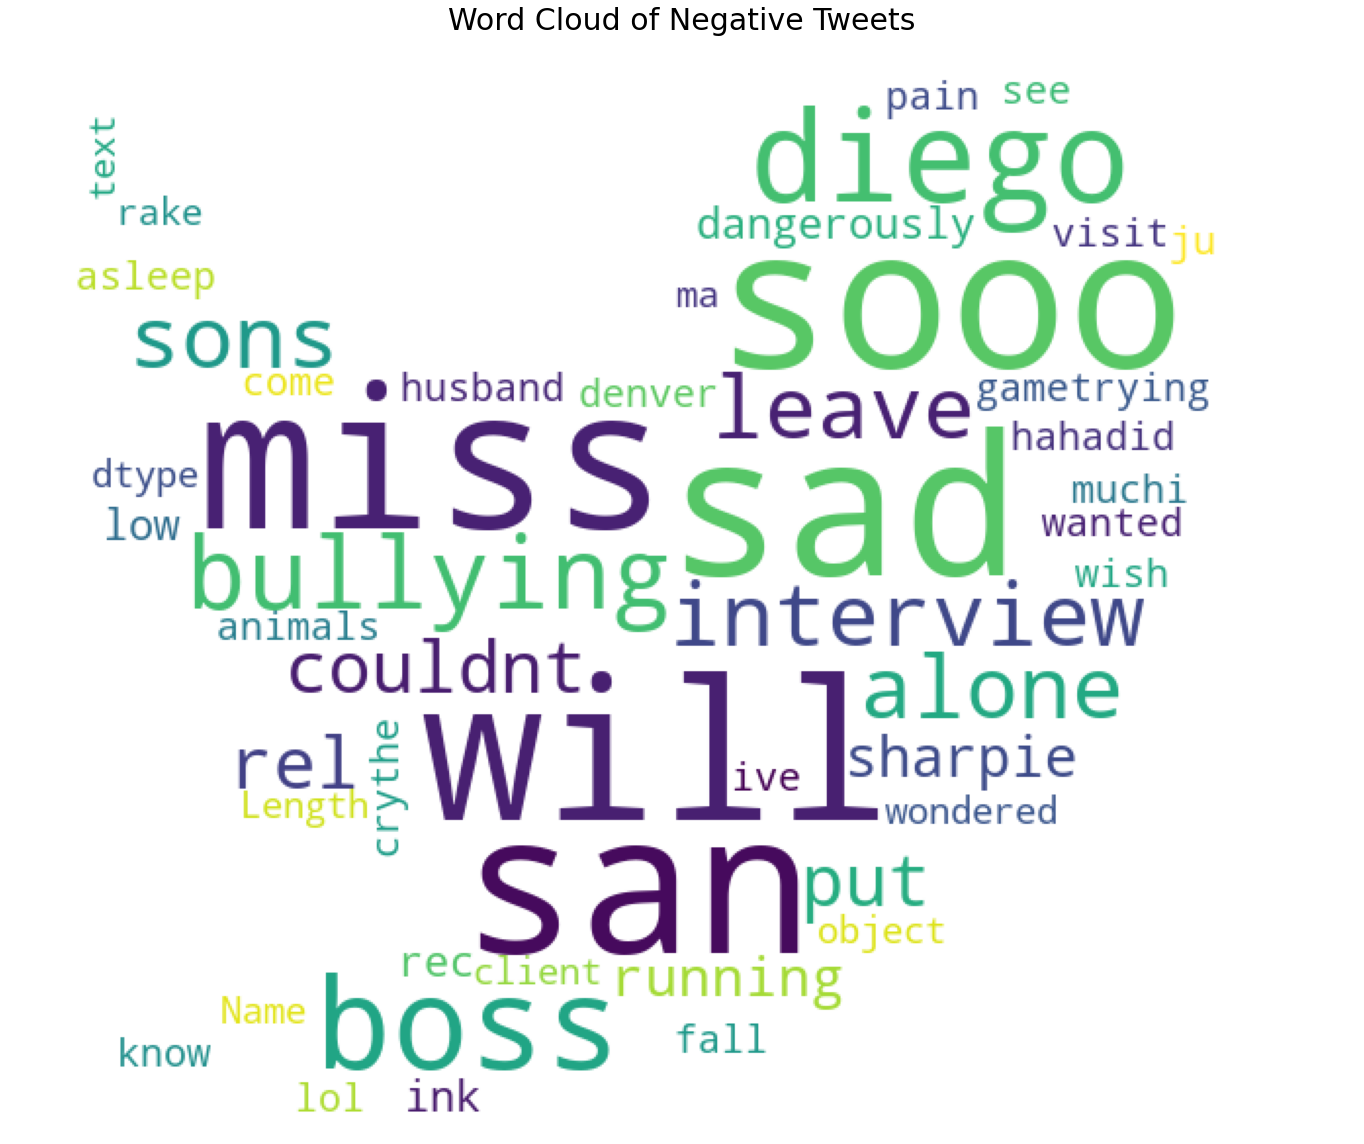

In [ ]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)